## Imports

In [80]:
# Data manipulation 
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Dimensionality reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, KernelPCA

# Clustering
from sklearn.cluster import KMeans 
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import silhouette_score

In [2]:
# run some files containing custom functions
%run -i '../scripts/helper_functions.py'

## Load and examine the data

In [3]:
df = pd.read_csv('../data/sentence.csv') 
df.head()

,sentence,company,sentiment
0,I CALLED AND ASKED THEM WHY I WAS GETTING INTE...,Walmart MASTERCARD,0.8647
1,Excellent rewards and redeem easily when makin...,Walmart MASTERCARD,0.8481
2,I must note that I had also received 2 previou...,Walmart MASTERCARD,0.8225
3,After 6 weeks and a few major purchases I was ...,Walmart MASTERCARD,0.7943
4,I have the Walmart Mastercard for over 2 years...,Walmart MASTERCARD,0.7845


In [4]:
df.shape

(111357, 3)

## Sentiment categorization

In [5]:
df = df[df.sentiment != 0] # Remove neutral reviews

In [6]:
df['positivity'] = np.where(df.sentiment > 0,1,0 ) # Positivity score based on sentiments

In [7]:
(df['positivity'].value_counts()/len(df))*100

1    72.408513
0    27.591487
Name: positivity, dtype: float64

## Tokens and Bigrams

In [8]:
df['tokens'] = df.sentence.apply(my_tokenizer) # Converts text to tokens

In [20]:
df['bigram_tokens'] = add_bigram(df.tokens) # Add bigrams

In [22]:
df.head()

,sentence,company,sentiment,positivity,tokens,bigram_tokens
0,I CALLED AND ASKED THEM WHY I WAS GETTING INTE...,Walmart MASTERCARD,0.8647,1,"[interest, close, guy, charge, interest, reocc...","[interest, close, guy, charge, interest, reocc..."
1,Excellent rewards and redeem easily when makin...,Walmart MASTERCARD,0.8481,1,"[excellent, reward, redeem, easily, purchase, ...","[excellent, reward, redeem, easily, purchase, ..."
2,I must note that I had also received 2 previou...,Walmart MASTERCARD,0.8225,1,"[must, note, previous, letter, walmart, offeri...","[must, note, previous, letter, walmart, offeri..."
3,After 6 weeks and a few major purchases I was ...,Walmart MASTERCARD,0.7943,1,"[week, major, purchase, close, limit, since, p...","[week, major, purchase, close, limit, since, p..."
4,I have the Walmart Mastercard for over 2 years...,Walmart MASTERCARD,0.7845,1,"[walmart, year, month, ago, duplicate, charge,...","[walmart, year, month_ago, duplicate, charge, ..."


##  Word2vec embeddings

In [24]:
token_list = df.bigram_tokens.to_list() # list of bigram tokens

In [25]:
model = word2vec_embedding(token_list) # Train word2vec

Let's check for similar words in the vocabulary

In [35]:
model.wv.most_similar(positive=['fee'] , topn=5)

[('monthly', 0.9424136281013489),
 ('interest', 0.9234060049057007),
 ('late_fee', 0.9119032025337219),
 ('waive', 0.9028468132019043),
 ('clobber', 0.898446798324585)]

In [36]:
model.wv.most_similar(positive=['cash_back'] , topn=5)

[('cashback', 0.991500735282898),
 ('category', 0.9824367761611938),
 ('mile', 0.9770166277885437),
 ('reward', 0.9723931550979614),
 ('gas', 0.968269944190979)]

In [51]:
model.wv.most_similar(positive=['point'] , topn=5)

[('mile', 0.9876993894577026),
 ('earn', 0.9782021641731262),
 ('category', 0.9768952131271362),
 ('gas', 0.9761845469474792),
 ('cash', 0.969017744064331)]

In [52]:
X = model.wv[model.wv.vocab] # Feature matrix 
X.shape

(11839, 300)

## Dimensionality reduction

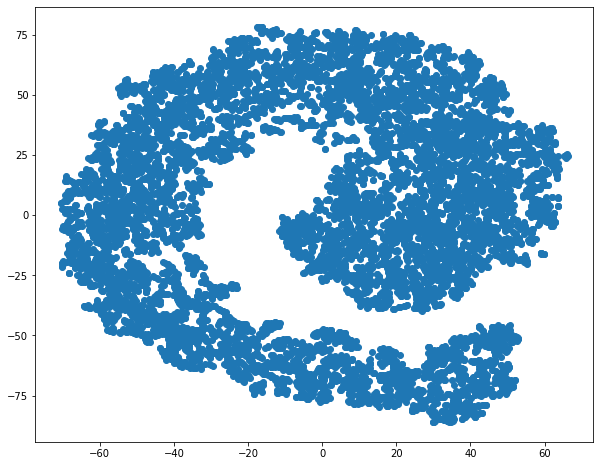

In [39]:
tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

plt.figure(figsize=(10,8))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1])

# Clustering

## K-means

In [62]:
# Building and fitting the model 
kmeans_per_k = [KMeans(n_clusters=k, n_jobs=-1, random_state=0).fit(X)  for k in range(1,10)]
inertias = [model.inertia_ for model in kmeans_per_k]

Text(0.5, 1.0, 'The Elbow Method using Inertia')

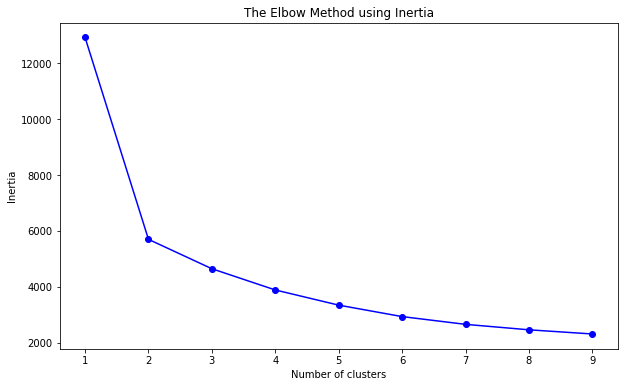

In [76]:
plt.figure(figsize = (10,6))
plt.plot(range(1,10), inertias, 'bo-') 
plt.xlabel('Number of clusters') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
#plt.xlim([0,10])

In [65]:
silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k[1:]]

Text(0, 0.5, 'Silhouette score')

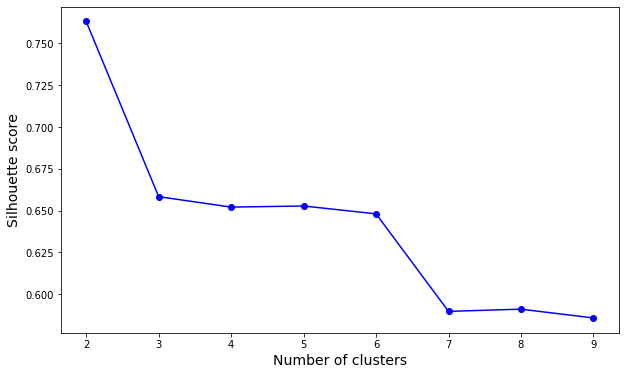

In [66]:
plt.figure(figsize=(10, 6))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("Number of clusters", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)

## Gaussian mixture

In [77]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 10)]

In [78]:
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

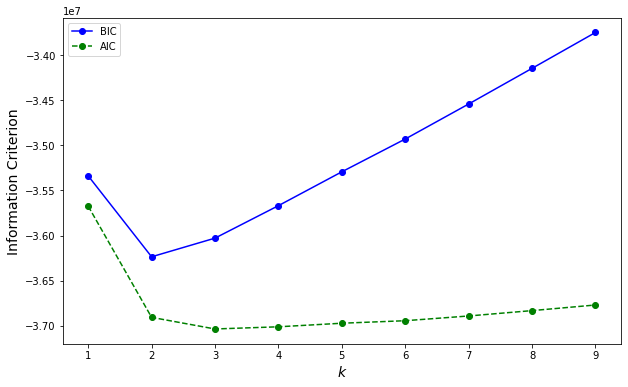

In [79]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), bics, "bo-", label="BIC")
plt.plot(range(1, 10), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.legend()
#plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])